# Exploring Factors Associated with No-Show Appointments in Medical Setting

## Table of Contents

- [Abstraction](#abstraction)
- [Data Loading](#data-loading)
- [Feature Engineering and Data Cleaning](#feature-engineering-and-data-cleaning)
- [EDA](#eda)
- [Model Training and Evaluation](#model-training-and-evaluation)
- [Model Interpretation](#model-interpretation)
- [Discussion](#discussion)
- [Summary](#summary)
- [References](#references)

## Abstraction<a name="abstraction"></a>

The purpose of this project is to explore a dataset of medical appointments and investigate the factors that are associated with patients not showing up for their appointments. The dataset contains information on over 100,000 appointments and includes variables such as patient age, gender, medical history, and whether or not they received a reminder SMS. 

The key questions we aim to answer are: 
* What are the main factors associated with no-show appointments
* How can we use this information to improve the scheduling process and reduce the number of missed appointments?

Missed appointments can have serious consequences for both patients and healthcare providers, such as delayed diagnosis and treatment, wasted resources, and decreased patient satisfaction. Therefore, understanding the factors that contribute to missed appointments is important for improving the quality of care and reducing costs.

We utilize machine learning method, tree-based model to find the effectable factors to the now show response. 

The dataset is licensed under CC BY-NC-SA 4.0 and was obtained from Kaggle's dataset repository, https://www.kaggle.com/datasets/joniarroba/noshowappointments?datasetId=792. The response variable in this dataset is whether or not the patient showed up for the appointment, and all other variables are considered predictors.

### Install necessary libraries

In [122]:
import warnings
warnings.simplefilter("ignore", FutureWarning)

In [123]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  make_scorer, accuracy_score, roc_auc_score, mean_squared_error

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

random.seed(100)

### Set hyper parameters and helper functions

In [124]:
random_state = 124
test_size = 0.2
min_samples_leaf = 25
scoring = {"accuracy": make_scorer(accuracy_score),
           "ROC_AUC": make_scorer(roc_auc_score),
           "MSE": make_scorer(mean_squared_error)}
ordered_neigbours = ['JARDIM DA PENHA', 'MATA DA PRAIA', 'PONTAL DE CAMBURI', 'REPÚBLICA',         'GOIABEIRAS', 'ANDORINHAS', 'CONQUISTA', 'NOVA PALESTINA', 'DA PENHA',         'TABUAZEIRO', 'BENTO FERREIRA', 'SÃO PEDRO', 'SANTA MARTHA', 'SÃO CRISTÓVÃO',         'MARUÍPE', 'GRANDE VITÓRIA', 'SÃO BENEDITO', 'ILHA DAS CAIEIRAS',         'SANTO ANDRÉ', 'SOLON BORGES', 'BONFIM', 'JARDIM CAMBURI', 'MARIA ORTIZ',         'JABOUR', 'ANTÔNIO HONÓRIO', 'RESISTÊNCIA', 'ILHA DE SANTA MARIA',         'JUCUTUQUARA', 'MONTE BELO', 'MÁRIO CYPRESTE', 'SANTO ANTÔNIO', 'BELA VISTA',         'PRAIA DO SUÁ', 'SANTA HELENA', 'ITARARÉ', 'INHANGUETÁ', 'UNIVERSITÁRIO',         'SÃO JOSÉ', 'REDENÇÃO', 'SANTA CLARA', 'CENTRO', 'PARQUE MOSCOSO',         'DO MOSCOSO', 'SANTOS DUMONT', 'CARATOÍRA', 'ARIOVALDO FAVALESSA',         'ILHA DO FRADE', 'GURIGICA', 'JOANA D´ARC', 'CONSOLAÇÃO', 'PRAIA DO CANTO',         'BOA VISTA', 'MORADA DE CAMBURI', 'SANTA LUÍZA', 'SANTA LÚCIA',         'BARRO VERMELHO', 'ESTRELINHA', 'FORTE SÃO JOÃO', 'FONTE GRANDE',         'ENSEADA DO SUÁ', 'SANTOS REIS', 'PIEDADE', 'JESUS DE NAZARETH',         'SANTA TEREZA', 'CRUZAMENTO', 'ILHA DO PRÍNCIPE', 'ROMÃO', 'COMDUSA',         'SANTA CECÍLIA', 'VILA RUBIM', 'DE LOURDES', 'DO QUADRO', 'DO CABRAL', 'HORTO',         'SEGURANÇA DO LAR', 'ILHA DO BOI', 'FRADINHOS', 'NAZARETH', 'AEROPORTO', 'ILHAS OCEÂNICAS DE TRINDADE', 'PARQUE INDUSTRIAL']
neibours_to_int = {are: i for i, are in enumerate(ordered_neigbours)}

In [125]:
# helper functions
def get_scores(model, X_test, y_test, cv=5, scoring=scoring):
    scores = cross_validate(model, X_test, y_test, cv=cv, scoring=scoring)
    print("Accuracy: %.3f" % np.mean(scores["test_accuracy"]))
    print("ROC_AUC: %.3f" % np.mean(scores["test_ROC_AUC"]))
    print("MSE: %.3f" % np.mean(scores["test_MSE"]))

def get_importance_plot(model, X_train):
    imps = pd.Series(model.feature_importances_, index=X_train.columns)
    imps = imps.sort_values(ascending=True)

    sns.barplot(x=imps, y=imps.index)
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")

def get_region(n):
    for key, val in neibours_to_int.items():
        if key == n:
            return val
    return None

## Data Loading<a name="data-loading"></a>

In [126]:
df = pd.read_csv("kaggle/input/noshowappointments/KaggleV2-May-2016.csv", low_memory=False)
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


The output of `df.info()` shows that the dataset contains `110527` entries and 14 columns. All columns have no missing values.

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


The `df.describe()` shows some insight:

* The `Age` ranges from `-1` and 115. `-1` age doesn't make sense
* The mean `Age` is about 37 years
* The painent who have `Handcap` are small amount of all dataset
* About 32 % parints got SMS reminder

In [128]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


Here is the all unique number and variable each column contains. One interesting point is patientId uqnique number is less than that of AppointmentID. It's possible that a patient may have scheduled multiple appointments, but didn't show up for some of them.

In [129]:
print(df.nunique())
for col in df.columns[2:]:
    print(col, ": ", df[col].unique())

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64
Gender :  ['F' 'M']
ScheduledDay :  ['2016-04-29T18:38:08Z' '2016-04-29T16:08:27Z' '2016-04-29T16:19:04Z' ...
 '2016-04-27T16:03:52Z' '2016-04-27T15:09:23Z' '2016-04-27T13:30:56Z']
AppointmentDay :  ['2016-04-29T00:00:00Z' '2016-05-03T00:00:00Z' '2016-05-10T00:00:00Z'
 '2016-05-17T00:00:00Z' '2016-05-24T00:00:00Z' '2016-05-31T00:00:00Z'
 '2016-05-02T00:00:00Z' '2016-05-30T00:00:00Z' '2016-05-16T00:00:00Z'
 '2016-05-04T00:00:00Z' '2016-05-19T00:00:00Z' '2016-05-12T00:00:00Z'
 '2016-05-06T00:00:00Z' '2016-05-20T00:00:00Z' '2016-05-05T00:00:00Z'
 '2016-05-13T00:00:00Z' '2016-05-09T00:00:00Z' '2016-05-25T00:00:00Z'
 '2016-05-11T00:00

## Feature Engineering and Data Cleaning<a name="feature-engineering-and-data-cleaning"></a>

### Feature engineering

I converted datetime features into integer-based features. By doing this, my model later will be able to interpret and use these features more easily.

I also use LabelEncoder to convert categorical features into numerical ones. This is a common technique used to transform non-numerical data into a format for later model training step.

In [130]:
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"])
df["ScheduledDay"] = pd.to_datetime(df["ScheduledDay"])
df["WaitingDay"] = df["AppointmentDay"] - df["ScheduledDay"]
df["WaitingDay"] = df["WaitingDay"].dt.days + 1

df["ScheduledDay_year"] = df["ScheduledDay"].dt.year
df["ScheduledDay_month"] = df["ScheduledDay"].dt.month
df["ScheduledDay_weekday"] = df["ScheduledDay"].dt.day_name()
df["ScheduledDay_day"] = df["ScheduledDay"].dt.day

df["AppointmentDay_year"] = df["AppointmentDay"].dt.year
df["AppointmentDay_month"] = df["AppointmentDay"].dt.month
df["AppointmentDay_weekday"] = df["AppointmentDay"].dt.day_name()
df["AppointmentDay_day"] = df["AppointmentDay"].dt.day

df["Neighbourhood"] = df["Neighbourhood"].apply(get_region)

le = LabelEncoder()
for col in ["Gender", "No-show", "AppointmentDay_weekday", "ScheduledDay_weekday"]:
    df[col] = le.fit_transform(df[col])

### Data cleaning

We cleaned data to ensure there're no nonsense entries.

1. Appointment day can't be before scheduling day
2. Negative age can't be.

In [131]:
df.drop(df[df["WaitingDay"] < 0].index, inplace=True)
df[df["WaitingDay"] < 0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,No-show,WaitingDay,ScheduledDay_year,ScheduledDay_month,ScheduledDay_weekday,ScheduledDay_day,AppointmentDay_year,AppointmentDay_month,AppointmentDay_weekday,AppointmentDay_day


In [132]:
df.drop(df[df["Age"] < 0].index, inplace=True)
df[df["Age"] < 0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,No-show,WaitingDay,ScheduledDay_year,ScheduledDay_month,ScheduledDay_weekday,ScheduledDay_day,AppointmentDay_year,AppointmentDay_month,AppointmentDay_weekday,AppointmentDay_day


## EDA<a name="eda"></a>

The following 4 EDA plots shows:

* The first pie chart indicates show vs noshow ration. 79.8% patients show, while 20.2% ones don't. If we predict all patients show, it will give roughly 80% accuracy.

* The second table indicates patients who show or no show have some distinct features. There's no obious difference between show or noshow patients, but younder patients tend to noshow.

* The third headmap shows no obious correlation among all of 2 features.

* The 4th pairplot shows, patient show received SMS tend to no show, and `0` waiting day patient are likely to show.

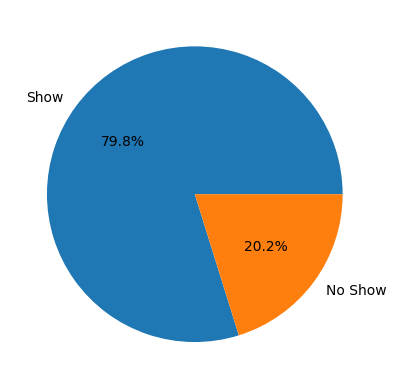

In [133]:
plt.pie(df["No-show"].value_counts(), labels=["Show", "No Show"], autopct="%.01f%%")
plt.show()

In [134]:
df.groupby("No-show")["Age", "Scholarship", "SMS_received"].mean()

,Age,Scholarship,SMS_received
No-show,,,
0,37.790504,0.093904,0.291337
1,34.317872,0.115533,0.438469


<Axes: >

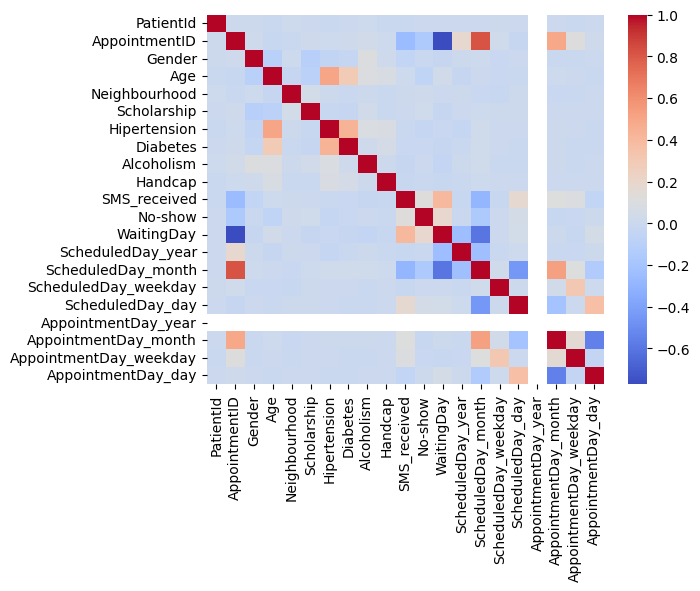

In [135]:
sns.heatmap(df.corr(), cmap="coolwarm")

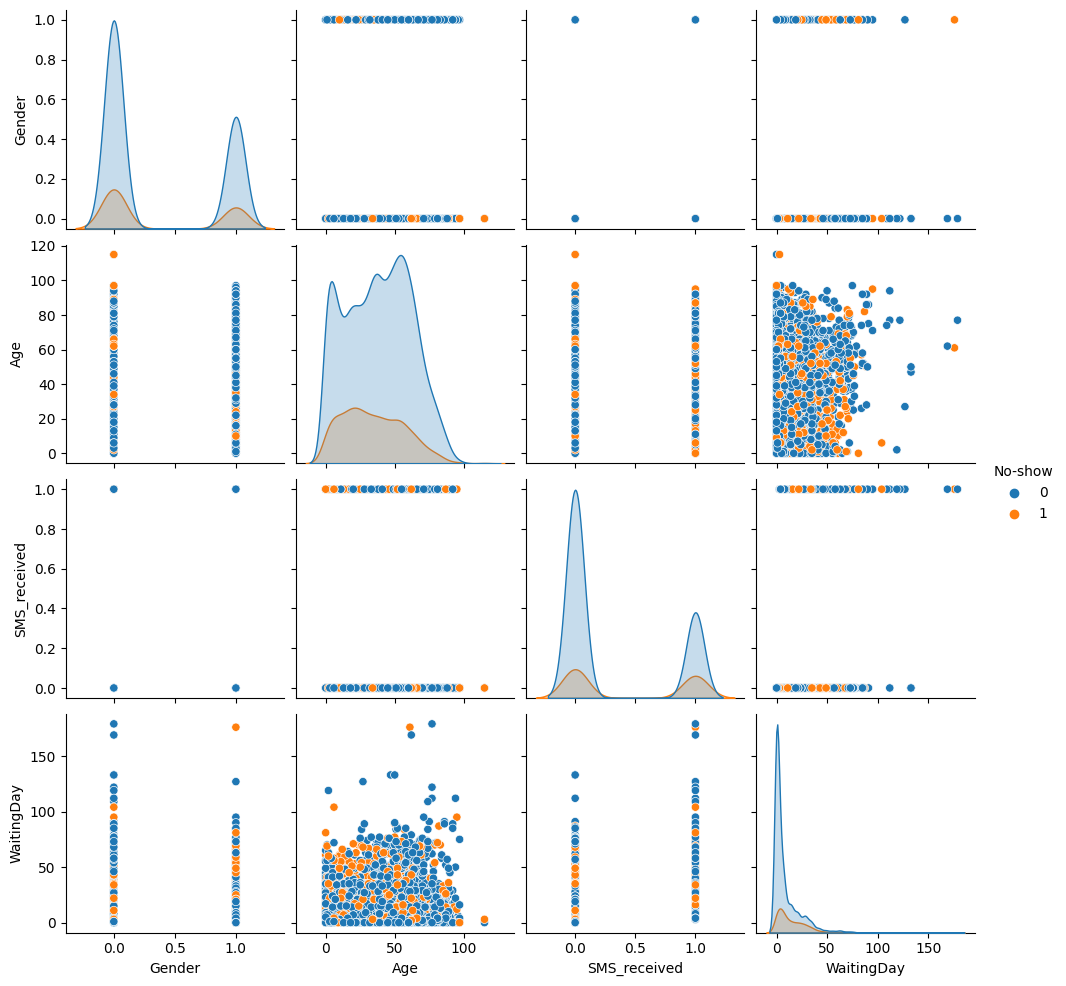

In [136]:
cols = ["Gender", "Age", "SMS_received", "WaitingDay"]
sns.pairplot(df.sample(10000), vars=cols, hue="No-show")
plt.show()

### Prepare dataset

We don't need "ScheduledDay" and "AppointmentDay" since those 2 data are already included in another column, like "AppointmentDay_year", "AppointmentDay_month", and so forth. The training dataset has `88416` entries, while `22105` for testing.

In [137]:
drop_cols = ["No-show", "PatientId", "AppointmentID", "ScheduledDay", "AppointmentDay"]
X = df.drop(drop_cols, axis=1)
y = df["No-show"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
print(len(X_train), len(X_test))

88416 22105


## Model Training and Evaluation<a name="model-training-and-evaluation"></a>

I took an iterative process to train the model. I utilize 3 metrics for evaluation, accuracy, ROC_AUC, and MSE. This project is binary classification problem so accuracy is the most important but it doesn't give us good feedback for how well model trains. Therefore I put MSE and ROC_AUC as well. Even if accuracy doesn't change by new modification, while other metrics shows improvement, I find new addition better.

The iteratve process as follows:

0. Prepare dataset
1. Make the model
2. Evaluate its accuracy, ROC_AUC, and MSE
3. Get feature importance
4. Going back to step.0 and change dataset or model based on step3 feature importance

First iteration:
In the first iteration, I created a baseline model using the DecisionTreeClassifier and evaluated it using the get_scores method. I also obtained the feature importance plot using the get_importance_plot function.

Second iteration:
Based on the feature importance plot, I found that the year and month columns had little effect on the response, so I decided to remove them. I also removed the day columns since they were redundant with the waitingDay feature. I then trained another decision tree with the same parameters and evaluated it, but the score did not change significantly.

Third iteration:
For the third iteration, I added some additional columns to the dataset and created a new dataset. I then trained another decision tree with the same parameters as before and got a slightly better result than the previous iteration, so I decided to keep going.

Fourth iteration:
In the fourth iteration, I used the RandomForestClassifier and got a slightly better result. I then obtained the feature importance plot and used it to create a new dataset with only the most important features. I trained another random forest with this new dataset and obtained the final result.


### First iteration

Accuracy: 0.776
ROC_AUC: 0.537
MSE: 0.224


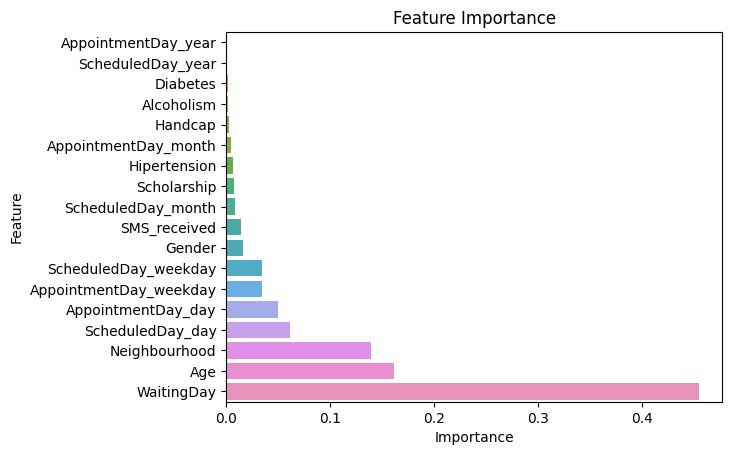

In [138]:
model_1 = DecisionTreeClassifier(random_state=random_state, min_samples_leaf=min_samples_leaf)
model_1.fit(X_train, y_train)
model_1.score(X_test, y_test)
get_scores(model_1, X_test, y_test)
get_importance_plot(model_1, X_train)

### Second iteration

In [139]:
drop_cols += ["ScheduledDay_year", "ScheduledDay_month", "ScheduledDay_day", "AppointmentDay_year", "AppointmentDay_month", "AppointmentDay_day"]
X = df.drop(drop_cols, axis=1)
y = df["No-show"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

model_2 = DecisionTreeClassifier(random_state=random_state, min_samples_leaf=min_samples_leaf)
model_2.fit(X_train, y_train)
model_2.score(X_test, y_test)
get_scores(model_2, X_test, y_test)

Accuracy: 0.780
ROC_AUC: 0.537
MSE: 0.220


### Third iteration

In this iteration, I put some additional columns to dataframe so that the model fit data more easily by getting some pattern of data. Here is the new columns:

* `prev_shows_num` represents the number of previous appointments where the patient showed up. 

* `prev_noshows_num` represents the number of previous appointments where the patient did not show up. 

* `is_prev_noshows` is a binary indicator of whether the patient has ever missed an appointment before. 

* `days_since_last` represents the number of days since the patient's last appointment. 

In [140]:
df = df.sort_values(["PatientId", "AppointmentDay"])
df["prev_shows_num"] = df.groupby("PatientId")["No-show"].apply(lambda x: (x==0).shift().cumsum().fillna(0))
df["prev_noshows_num"] = df.groupby("PatientId")["No-show"].apply(lambda x: (x==1).shift().cumsum().fillna(0))
df["is_prev_noshows"] = df.groupby("PatientId")["No-show"].apply(lambda x: (x==1).shift().fillna(False))
df["is_prev_noshows"] = le.fit_transform(df["is_prev_noshows"])
df["days_since_last"] = (df["AppointmentDay"] - df.groupby("PatientId")["AppointmentDay"].shift(1)).dt.days
df["days_since_last"] = df["days_since_last"].fillna(0)

df = df.sample(frac=1).reset_index(drop=True)

In [141]:
X = df.drop(drop_cols, axis=1)
y = df["No-show"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

model_3 = DecisionTreeClassifier(random_state=random_state, min_samples_leaf=min_samples_leaf)
model_3.fit(X_train, y_train)
get_scores(model_3, X_test, y_test)

Accuracy: 0.784
ROC_AUC: 0.557
MSE: 0.216


### Forth iteration(the final model)

In [142]:
rf_model_1 = RandomForestClassifier(random_state=random_state, n_estimators=100, min_samples_leaf=min_samples_leaf)
rf_model_1.fit(X_train, y_train)
get_scores(rf_model_1, X_test, y_test)

Accuracy: 0.803
ROC_AUC: 0.524
MSE: 0.197


Accuracy: 0.804
ROC_AUC: 0.527
MSE: 0.196


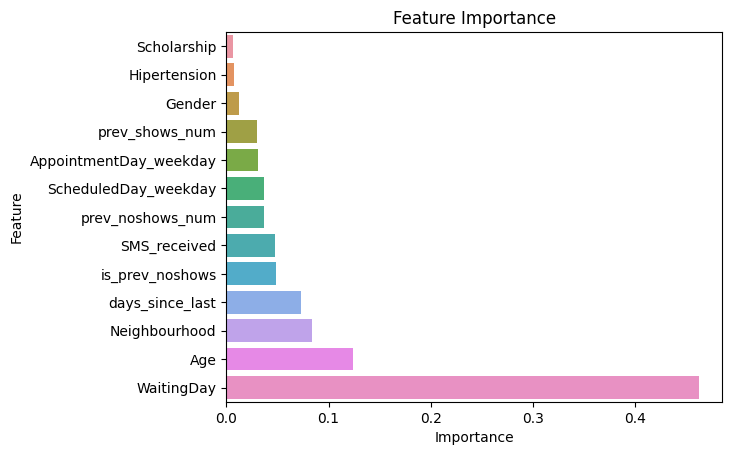

In [143]:
imps = pd.Series(rf_model_1.feature_importances_, index=X_train.columns)
imps = imps.sort_values(ascending=True)

X = df[imps[imps > 0.005].index]
y = df["No-show"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

rf_model_2 = RandomForestClassifier(random_state=random_state, n_estimators=100, min_samples_leaf=min_samples_leaf)
rf_model_2.fit(X_train, y_train)
get_scores(rf_model_2, X_test, y_test)
get_importance_plot(rf_model_2, X_train)

### Optimization step but did't improve model

The code below utilize `RandomizedSearchCV` to find the better hyper parameter values for random forest. The code works, while taking a lot of time, it does not always gurantee to result in a better model . Therefore, I commented it out for now. However, it does help to find the best parameter while training. For instance, we set `min_samples_leaf` to `25` based on this randomized search. It didn't give the good result for making model, but give for finding good parameters.

In [144]:
# Note the code below takes much memory and time

# rf_params = {
#     "n_estimators": [100, 150, 200],
#     "criterion": ["gini", "entropy"],
#     "max_depth": [None, 5, 10, 15],
#     "min_samples_leaf": [5, 10, 20, 40],
#     "max_features": ["auto", "sqrt", "log2"]
# }

# rf_model_3 = RandomForestClassifier(random_state=random_state)
# rf_random_search = RandomizedSearchCV(rf_model_3, rf_params, cv=5, n_iter=20, random_state=random_state, scoring="accuracy")
# rf_random_search.fit(X_train, y_train)

# print("Best Hyper params for random forest classifier: ")
# print(rf_random_search.best_params_)

# rf_model_tuned = RandomForestClassifier(**rf_random_search.best_params_, random_state=random_state)
# rf_model_tuned.fit(X_train, y_train)
# get_scores(rf_model_tuned, X_test, y_test)

## Model Interpretation<a name="model-interpretation"></a>

Model interpretation can help us gain some understanding why our model make the prediction if patient comes or not. This gives not only keys to undertand how model improve while training, but also make improvement for communicating with stakeholders in real application. 

For example, longer awaiting time has a relatively strong contribution to the noshow response. This might suggest that the patient's appointment are more likely to be missed.

Green colored features indicates positive effects to missed appointment, while red colored features are for negative effects to missed appointment. If the blue colored net value is over 0, patient is likely to miss the appointments.

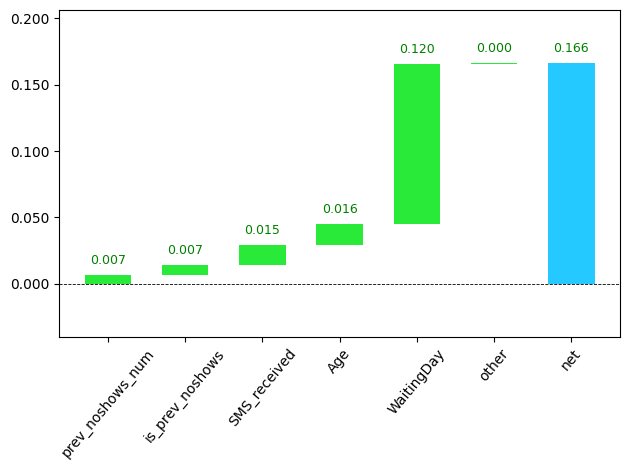

In [146]:
pred, bias, contrb = treeinterpreter.predict(rf_model_2, X_test.iloc[15:20].values)
contrb = [contrb[0][i][0] for i in range(len(contrb[0]))]
waterfall(X_test.columns.values, 
       contrb,
       threshold=0.05,
       rotation_value=50, 
       formatting="{:,.3f}");

## Discussion<a name="discussion"></a>

### Answers to main questions

We suggest following answers based on the dataset anaysis and final model's output.

Questions:

1. What are the main factors associated with no-show appointments
2. How can we use this information to improve the scheduling process and reduce the number of missed appointments?

Answers:
1. The main factors associated with no-show appointments are How many days between scheduled and appointment, how old the patients are, where they live, the last day they came, is previous time no show?. Those criteria mostly indicate if the patient does show or not.
2. To reduce the number of missed appointments, the scheduling process could be improved by shortening the waiting time between scheduling and appointment, as longer waiting times were found to increase the likelihood of no-shows. SMS is sent to the patient who are likely to noshow but not sure if it help to reduce the miss appointments number. Another reminder like calling would be alternative option.


### Unique approaches taken
We took some unique approaches to improve the accuracy and effectiveness of our models.

Firstly, we added several new columns such as days_since_last to make it easier to detect patterns in the data. We also reordered the neighbourhood column geographically to see if this would affect the outcome.

Secondly, we used randomized search cross-validation (RandomizedSearchCV) for hyperparameter tuning instead of the more traditional grid search. This allowed us to efficiently search the hyperparameter space and find the best set of hyperparameters for our model.

Lastly, we utilized several evaluation metrics, including precision, recall, and F1 score, in addition to accuracy to get a more detailed understanding of our model's performance. By using these metrics, we were able to identify areas where our model was performing well and areas where it needed improvement.

Overall, these innovative approaches allowed us to create a more accurate and effective model for predicting no-show appointments in medical settings.

## Summary<a name="summary"></a>

The final model predicts over 80% accuracy if patient does show or not. We loaded and cleaned the dataset from kaggle data repository, and performed exploratory data analysis to understand the patterns and relationships between variables. We used machine learning tree-based model to predict no-show appointments. We also interpreted the models to identify the main factors associated with no-show appointments and how this information can be used to improve the scheduling process. Overall, this project highlights the importance of data analysis and modeling in healthcare and how it can help healthcare providers optimize their resources.

## References<a name="references"></a>

This project github repo:
* https://github.com/Akitsuyoshi/supervised_ml_app.git

EDA refs:
* https://www.kaggle.com/datasets/joniarroba/noshowappointments?datasetId=792
* https://insidelearningmachines.com/build-a-random-forest-in-python/
* https://www.kaggle.com/code/samratp/predict-show-noshow-eda-visualization-model
* https://www.kaggle.com/code/ahmedmohameddawoud/why-patients-do-not-show-up-for-the-appointment
* https://www.kaggle.com/code/jhoward/how-random-forests-really-work/

Model building refs:
* https://course.fast.ai/Lessons/lesson6.html

Model interpretation refs:
* https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb